In [24]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
from pandas import ExcelWriter

fig_dir='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Saildrone/'

icefile='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Ice Present.xlsx'
DWfile='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/DiurnalWarming Present.xlsx'

baddir='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/'

data_dir = '//white_home_pc/f/data/cruise_data/saildrone/2019_arctic/post_mission_combined/'

data_dir_out = '//white_home_pc/f/data/cruise_data/saildrone/2019_arctic/post_mission_combined_flags/'



## Read in all the cruise full data

- swap dims from obs to time
- I checked & time = for both trajectories

In [25]:
ds = xr.open_mfdataset(data_dir+'*.nc',combine='nested',concat_dim='trajectory').load()



## read in ice, diurnal warming, and surface coolingpresent file

This file is a combination of the NOAA ice file & own analysis of data based on STD of salinity and SST

In [30]:

badfile=baddir+'Arctic_bad.xlsx'
ds_tem = pd.read_excel(badfile, sheet_name='warm',index_col=1)
ds_warm = ds_tem.to_xarray()
ds_tem = pd.read_excel(badfile, sheet_name='cold',index_col=1)
ds_cool = ds_tem.to_xarray()

tem=ds_warm
for i in range(tem.usv.size):
    tt=pd.to_datetime(str(tem.start_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.start_time[i]=tt64
    tt=pd.to_datetime(str(tem.stop_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.stop_time[i]=tt64
ds_warm=tem
tem=ds_cool
for i in range(tem.usv.size):
    tt=pd.to_datetime(str(tem.start_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.start_time[i]=tt64
    tt=pd.to_datetime(str(tem.stop_time[i].data),format='%Y-%m-%dT%H:%M:%S')
    tt64=np.datetime64(tt)
    tem.stop_time[i]=tt64
ds_cool=tem

tem_mask=np.zeros(ds.TEMP_AIR_MEAN.shape)
tem_mask = xr.DataArray(tem_mask,coords=[ds.trajectory,ds.time],dims=['trajectory','time'],
                                           attrs={'long_name':'Diurnal warming mask 1=warm'})
ds['warm_mask']=tem_mask
for iusv in range(2):
    tem =  ds_warm.sel(usv=int(ds.trajectory[iusv].data))
    ds_tem = ds.isel(trajectory=iusv)
    if tem.usv.size>1:
        for i in range(tem.usv.size):
            cond = (ds_tem.time>=tem.start_time[i]) & (ds_tem.time<=tem.stop_time[i])
            ds_tem.warm_mask[cond]=1
    else:
        cond = (ds_tem.time>=tem.start_time) & (ds_tem.time<=tem.stop_time)
        ds_tem.warm_mask[cond]=1       
    ds['warm_mask'][iusv,:]=ds_tem.warm_mask

tem_mask=np.zeros(ds.TEMP_AIR_MEAN.shape)
tem_mask = xr.DataArray(tem_mask,coords=[ds.trajectory,ds.time],dims=['trajectory','time'],
                                           attrs={'long_name':'surface cooling mask 1=cool'})
ds['cool_mask']=tem_mask
for iusv in range(2):
    tem =  ds_cool.sel(usv=int(ds.trajectory[iusv].data))
    ds_tem = ds.isel(trajectory=iusv)
    if tem.usv.size>1:
        for i in range(tem.usv.size):
            cond = (ds_tem.time>=tem.start_time[i]) & (ds_tem.time<=tem.stop_time[i])
            ds_tem.cool_mask[cond]=1
    else:
        cond = (ds_tem.time>=tem.start_time) & (ds_tem.time<=tem.stop_time)
        ds_tem.cool_mask[cond]=1       
    ds['cool_mask'][iusv,:]=ds_tem.cool_mask

    
ds2 = pd.read_excel(icefile, sheet_name='data',index_col=0)
ds_ice = ds2.to_xarray()
tem_mask=np.zeros(ds.TEMP_AIR_MEAN.shape)
tem_mask = xr.DataArray(tem_mask,coords=[ds.trajectory,ds.time],dims=['trajectory','time'],
                                           attrs={'long_name':'surface cooling mask 1=cool'})
ds['ice_mask']=tem_mask
for iusv in range(2):
    tem =  ds_ice.sel(usv=int(ds.trajectory[iusv].data))
    ds_tem = ds.isel(trajectory=iusv)
    print(ds_tem)
    if tem.usv.size>1:
        for i in range(tem.usv.size):
            cond = (ds_tem.time>=tem.start_time[i]) & (ds_tem.time<=tem.stop_time[i])
            print(tem.start_time[i],tem.stop_time[i])
            ds_tem.ice_mask[cond]=1
    else:
        cond = (ds_tem.time>=tem.start_time) & (ds_tem.time<=tem.stop_time)
        ds_tem.ice_mask[cond]=1       
    ds['ice_mask'][iusv,:]=ds_tem.ice_mask  


<xarray.Dataset>
Dimensions:                         (time: 215731)
Coordinates:
  * time                            (time) datetime64[ns] 2019-05-14T23:00:00 ... 2019-10-11T18:30:00
    lat                             (time) float64 53.85 53.85 ... 53.85 53.85
    lon                             (time) float64 -166.6 -166.6 ... -166.6
    trajectory                      <U4 '1036'
Data variables:
    SOG                             (time) float64 1.41 1.716 ... 0.214 0.312
    SOG_FILTERED_MEAN               (time) float64 1.194 1.548 ... 0.211 0.273
    SOG_FILTERED_STDDEV             (time) float64 0.096 0.104 ... 0.015 0.033
    SOG_FILTERED_MAX                (time) float64 1.48 1.752 ... 0.245 0.333
    SOG_FILTERED_MIN                (time) float64 1.041 1.302 ... 0.167 0.207
    COG                             (time) float64 324.0 322.9 ... 344.7 346.3
    COG_FILTERED_MEAN               (time) float64 324.6 324.3 ... 350.1 346.3
    COG_FILTERED_STDDEV             (time) float

In [33]:
ds.to_netcdf(data_dir_out + 'saildrone-gen_5-arctic_misst_2019-sd10361037-20190514T230000-20191011T183000-1_minutes-v1.1575336154680-withSBE_flags_v02.nc')



PermissionError: [Errno 13] Permission denied: b'\\\\white_home_pc\\f\\data\\cruise_data\\saildrone\\2019_arctic\\post_mission_combined_flags\\saildrone-gen_5-arctic_misst_2019-sd10361037-20190514T230000-20191011T183000-1_minutes-v1.1575336154680-withSBE_flags_v02.nc'

In [36]:
ds.to_netcdf('C:/Users/gentemann/Google Drive/public/saildrone-gen_5-arctic_misst_2019-sd10361037-20190514T230000-20191011T183000-1_minutes-v1.1575336154680-withSBE_flags_v02.nc')

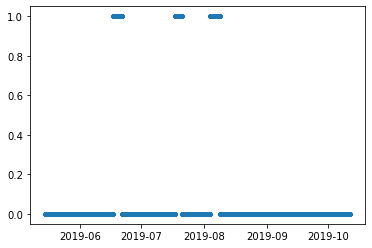

In [32]:
plt.plot(ds.time,ds.ice_mask[1,:],'.')

In [7]:
ds = xr.open_dataset(data_dir_out+'saildrone-gen_5-arctic_misst_2019-sd10361037-20190514T230000-20191011T183000-1_minutes-v1.1575336154680-withSBE_flags.nc')

In [8]:
ds = xr.open_dataset(data_dir_out+'saildrone-gen_5-arctic_misst_2019-sd10361037-20190514T230000-20191011T183000-1_minutes-v1.1575336154680-withSBE_flags.nc')
ds2=ds.where(ds.warm_mask>0,drop=True)
ds2.

<xarray.Dataset>
Dimensions:                         (time: 215731, trajectory: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2019-05-14T23:00:00 ... 2019-10-11T18:30:00
    lat                             (trajectory, time) float64 ...
    lon                             (trajectory, time) float64 ...
  * trajectory                      (trajectory) object '1036' '1037'
Data variables:
    SOG                             (trajectory, time) float64 ...
    SOG_FILTERED_MEAN               (trajectory, time) float64 ...
    SOG_FILTERED_STDDEV             (trajectory, time) float64 ...
    SOG_FILTERED_MAX                (trajectory, time) float64 ...
    SOG_FILTERED_MIN                (trajectory, time) float64 ...
    COG                             (trajectory, time) float64 ...
    COG_FILTERED_MEAN               (trajectory, time) float64 ...
    COG_FILTERED_STDDEV             (trajectory, time) float64 ...
    HDG                             (trajectory, time) float64 ...
    HDG_FILTERED_MEAN               (trajectory, time) float64 ...
    HDG_FILTERED_STDDEV             (trajectory, time) float64 ...
    ROLL_FILTERED_MEAN              (trajectory, time) float64 ...
    ROLL_FILTERED_STDDEV            (trajectory, time) float64 ...
    ROLL_FILTERED_PEAK              (trajectory, time) float64 ...
    PITCH_FILTERED_MEAN             (trajectory, time) float64 ...
    PITCH_FILTERED_STDDEV           (trajectory, time) float64 ...
    PITCH_FILTERED_PEAK             (trajectory, time) float64 ...
    HDG_WING                        (trajectory, time) float64 ...
    WING_HDG_FILTERED_MEAN          (trajectory, time) float64 ...
    WING_HDG_FILTERED_STDDEV        (trajectory, time) float64 ...
    WING_ROLL_FILTERED_MEAN         (trajectory, time) float64 ...
    WING_ROLL_FILTERED_STDDEV       (trajectory, time) float64 ...
    WING_ROLL_FILTERED_PEAK         (trajectory, time) float64 ...
    WING_PITCH_FILTERED_MEAN        (trajectory, time) float64 ...
    WING_PITCH_FILTERED_STDDEV      (trajectory, time) float64 ...
    WING_PITCH_FILTERED_PEAK        (trajectory, time) float64 ...
    WING_ANGLE                      (trajectory, time) float64 ...
    UWND_MEAN                       (trajectory, time) float64 ...
    UWND_STDDEV                     (trajectory, time) float64 ...
    VWND_MEAN                       (trajectory, time) float64 ...
    VWND_STDDEV                     (trajectory, time) float64 ...
    WWND_MEAN                       (trajectory, time) float64 ...
    WWND_STDDEV                     (trajectory, time) float64 ...
    GUST_WND_MEAN                   (trajectory, time) float64 ...
    GUST_WND_STDDEV                 (trajectory, time) float64 ...
    WIND_HEIGHT_MEAN                (trajectory, time) float64 ...
    WIND_HEIGHT_STDDEV              (trajectory, time) float64 ...
    TEMP_AIR_MEAN                   (trajectory, time) float64 ...
    TEMP_AIR_STDDEV                 (trajectory, time) float64 ...
    RH_MEAN                         (trajectory, time) float64 ...
    RH_STDDEV                       (trajectory, time) float64 ...
    BARO_PRES_MEAN                  (trajectory, time) float64 ...
    BARO_PRES_STDDEV                (trajectory, time) float64 ...
    PAR_AIR_MEAN                    (trajectory, time) float64 ...
    PAR_AIR_STDDEV                  (trajectory, time) float64 ...
    TEMP_IR_SKY_HULL_MEAN           (trajectory, time) float64 ...
    TEMP_IR_SKY_HULL_STDDEV         (trajectory, time) float64 ...
    TEMP_IR_SEA_HULL_UNCOMP_MEAN    (trajectory, time) float64 ...
    TEMP_IR_SEA_HULL_UNCOMP_STDDEV  (trajectory, time) float64 ...
    TEMP_IR_SEA_WING_UNCOMP_MEAN    (trajectory, time) float64 ...
    TEMP_IR_SEA_WING_UNCOMP_STDDEV  (trajectory, time) float64 ...
    WAVE_DOMINANT_PERIOD            (trajectory, time) float64 ...
    WAVE_SIGNIFICANT_HEIGHT         (trajectory, time) float64 ...
    TEMP_SBE37_MEAN            